In [1]:
# Update the PATH to include the user installation directory. 
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

# Restart the Kernel before you move on to the next step.

In [7]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [9]:
# Defining transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Loading the dataset
mnist_dataset = torchvision.datasets.MNIST(root="data", train=True, download=True, transform=transform)

# Defining the sizes of train, validation, and test sets
train_size = int(0.6 * len(mnist_dataset))  # 60% for training
val_size = int(0.2 * len(mnist_dataset))    # 20% for validation
test_size = len(mnist_dataset) - train_size - val_size  # Remaining for test (20%)

# Splitting the MNIST dataset 

train_dataset, val_dataset, test_dataset = random_split(mnist_dataset, [train_size, val_size, test_size])

# Create test set and define test dataloader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128)


In [10]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

6


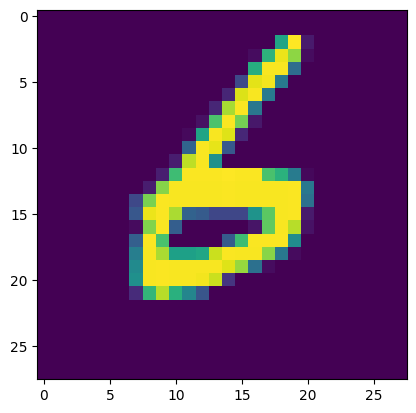

8


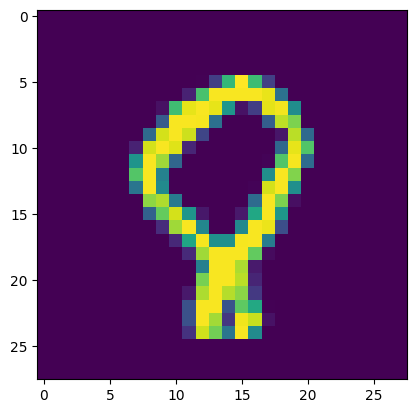

9


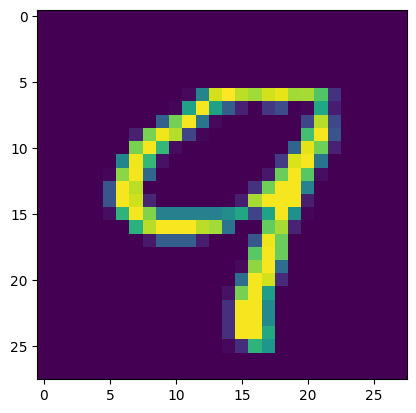

2


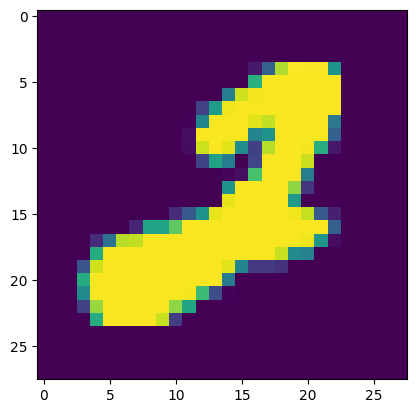

7


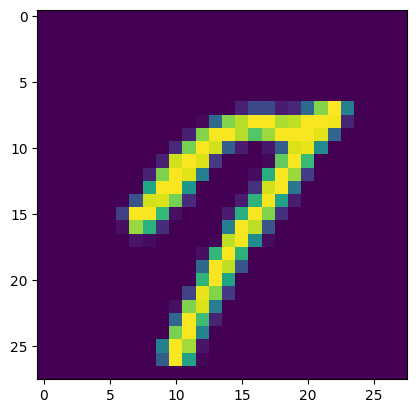

In [11]:
show5(train_loader)

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = nn.Linear(28 * 28 * 1, 256)
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, 64)
        self.layer4 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.2)  # Dropout layer to prevent overfitting
        
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.layer1(x))
        x = self.dropout(x)
        x = F.relu(self.layer2(x))
        x = self.dropout(x)
        x = F.relu(self.layer3(x))
        x = self.dropout(x)
        x = self.layer4(x)  
        return x

In [16]:
net = Net()

optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.99, weight_decay=0.001)
criterion = nn.CrossEntropyLoss()

In [17]:
# Move the model to the GPU if CUDA is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

Net(
  (layer1): Linear(in_features=784, out_features=256, bias=True)
  (layer2): Linear(in_features=256, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=64, bias=True)
  (layer4): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [19]:
# number of epochs
num_epochs = 20

# creating lists for loss history
train_loss_history = list()
val_loss_history = list()

# The start of the training
for epoch in range(num_epochs):
    # putting the model in training mode
    net.train()
    # setting the epoch loss and number of correct predictions to zero
    train_loss = 0.0
    train_correct = 0
    total_predictions = 0
    
    for i, data in enumerate(train_loader):
        inputs, labels = data
        
        if torch.cuda.is_available():
            inputs, labels = inputs.to(device), labels.to(device)
    
        optimizer.zero_grad()
    
        outputs = net(inputs)
    
        loss = criterion(outputs, labels)
    
        loss.backward()
    
        optimizer.step()
    
        _, preds = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        train_correct += (preds == labels).sum().item()
        train_loss += loss.item()
        
    print(f"Epoch {epoch + 1} training accuracy: {train_correct/total_predictions * 100:.2f}% training loss: {train_loss/len(train_loader):.5f}")
    train_loss_history.append(train_loss/len(train_loader))
    
    # The validation phase
    val_loss = 0.0
    val_correct = 0
    total_predictions = 0
    net.eval()
    for inputs, labels in val_loader:
        if torch.cuda.is_available():
            inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        _, preds = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        val_correct += (preds == labels).sum().item()
        val_loss += loss.item()
    print(f"Epoch {epoch + 1} validation accuracy: {val_correct/total_predictions * 100:.2f}% validation loss: {val_loss/len(val_loader):.5f}")
    val_loss_history.append(val_loss/len(val_loader))

Epoch 1 training accuracy: 67.45% training loss: 0.97130
Epoch 1 validation accuracy: 89.20% validation loss: 0.35626
Epoch 2 training accuracy: 86.47% training loss: 0.45660
Epoch 2 validation accuracy: 91.60% validation loss: 0.28719
Epoch 3 training accuracy: 87.57% training loss: 0.42940
Epoch 3 validation accuracy: 92.12% validation loss: 0.26866
Epoch 4 training accuracy: 88.17% training loss: 0.41234
Epoch 4 validation accuracy: 92.29% validation loss: 0.26838
Epoch 5 training accuracy: 87.84% training loss: 0.42043
Epoch 5 validation accuracy: 91.28% validation loss: 0.29678
Epoch 6 training accuracy: 86.88% training loss: 0.44483
Epoch 6 validation accuracy: 91.83% validation loss: 0.29238
Epoch 7 training accuracy: 86.86% training loss: 0.44671
Epoch 7 validation accuracy: 91.05% validation loss: 0.30232
Epoch 8 training accuracy: 86.61% training loss: 0.45744
Epoch 8 validation accuracy: 91.50% validation loss: 0.29637
Epoch 9 training accuracy: 86.47% training loss: 0.46711

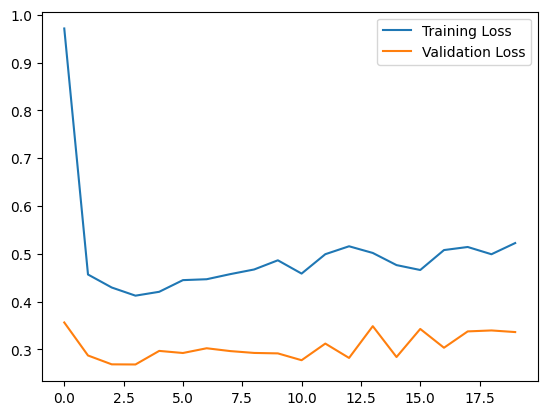

In [23]:
plt.plot(train_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.legend()
plt.show()

In [24]:
correct_predictions = 0
total_predictions = 0

for inputs, labels in test_loader:
    if torch.cuda.is_available():
        inputs, labels = inputs.to(device), labels.to(device)
        
    outputs = net(inputs)
    _, preds = torch.max(outputs.data, 1)
    total_predictions += labels.size(0)
    correct_predictions += (preds == labels).sum().item()
    accuracy = (correct_predictions / total_predictions) * 100
    
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 90.83%


## Improving your model

In [ ]:
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.99, weight_decay= 0.001)

In [25]:
# number of epochs
num_epochs = 20

# creating lists for loss history
train_loss_history = list()
val_loss_history = list()

# The start of the training
for epoch in range(num_epochs):
    # putting the model in training mode
    net.train()
    # setting the epoch loss and number of correct predictions to zero
    train_loss = 0.0
    train_correct = 0
    
    for i, data in enumerate(train_loader):
        inputs, labels = data
        
        if torch.cuda.is_available():
            inputs, labels = inputs.to(device), labels.to(device)
    
        optimizer.zero_grad()
    
        outputs = net(inputs)
    
        loss = criterion(outputs, labels)
    
        loss.backward()
    
        optimizer.step()
    
        _, preds = torch.max(outputs.data, 1)
        train_correct += (preds == labels).sum().item()
        train_loss += loss.item()
        
    print(f"Epoch {epoch + 1} training accuracy: {train_correct/len(train_loader.dataset) * 100:.2f}% training loss: {train_loss/len(train_loader):.5f}")
    train_loss_history.append(train_loss/len(train_loader))
    
    # The validation phase
    val_loss = 0.0
    val_correct = 0
    net.eval()
    for inputs, labels in test_loader:
        if torch.cuda.is_available():
            inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        _, preds = torch.max(outputs.data, 1)
        val_correct += (preds == labels).sum().item()
        val_loss += loss.item()
    print(f"Epoch {epoch + 1} validation accuracy: {val_correct/len(test_loader.dataset) * 100:.2f}% validation loss: {val_loss/len(test_loader):.5f}")
    val_loss_history.append(val_loss/len(test_loader))

Epoch 1 training accuracy: 84.63% training loss: 0.53864
Epoch 1 validation accuracy: 90.61% validation loss: 0.34908
Epoch 2 training accuracy: 84.60% training loss: 0.53659
Epoch 2 validation accuracy: 89.21% validation loss: 0.38762
Epoch 3 training accuracy: 84.90% training loss: 0.54237
Epoch 3 validation accuracy: 90.89% validation loss: 0.35322
Epoch 4 training accuracy: 85.50% training loss: 0.49777
Epoch 4 validation accuracy: 91.49% validation loss: 0.32810
Epoch 5 training accuracy: 85.76% training loss: 0.49979
Epoch 5 validation accuracy: 91.38% validation loss: 0.32714
Epoch 6 training accuracy: 85.38% training loss: 0.51960
Epoch 6 validation accuracy: 91.47% validation loss: 0.31879
Epoch 7 training accuracy: 85.22% training loss: 0.50833
Epoch 7 validation accuracy: 91.77% validation loss: 0.31680
Epoch 8 training accuracy: 85.31% training loss: 0.52007
Epoch 8 validation accuracy: 90.59% validation loss: 0.35429
Epoch 9 training accuracy: 85.00% training loss: 0.52441

In [26]:
correct_predictions = 0
total_predictions = 0

for inputs, labels in test_loader:
    if torch.cuda.is_available():
        inputs, labels = inputs.to(device), labels.to(device)
        
    outputs = net(inputs)
    _, preds = torch.max(outputs.data, 1)
    total_predictions += labels.size(0)
    correct_predictions += (preds == labels).sum().item()
    accuracy = (correct_predictions / total_predictions) * 100
    
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 88.52%


In [27]:
torch.save(net.state_dict(), "saved_model.pth")